# Notebook 2

## This notebook includes more recent work after performing some preliminary scratchwork (in 'MTA-brian') and performing Challenge 1.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import seaborn as sns

In [3]:
# Import local CSV files and change name of EXITS column

df_dec19 = pd.read_csv('december_turnstiles.csv', index_col = 0)
df_dec19 = df_dec19.rename(columns={'EXITS                                                               ':'EXITS'})
df_mar20 = pd.read_csv('march_turnstiles.csv', index_col = 0)
df_mar20 = df_mar20.rename(columns={'EXITS                                                               ':'EXITS'})
df_june20 = pd.read_csv('june_turnstiles.csv', index_col = 0)
df_june20 = df_june20.rename(columns={'EXITS                                                               ':'EXITS'})

In [4]:
# Functions to organize data by foot traffic, turnstiles, and traffic (credit: Lauren Fields)
"""
This is the original function

def combinedTraffic(dataframe):
    dataframe["FOOTTRAFFIC"] = dataframe["ENTRIES"] + dataframe["EXITS"]
    
def turnstileColumn(dataframe):
    '''
    Takes an MTA dataframe & creates a new column
    Where there's an index number for each Turn Stile in frame.
    '''
    eachTS = dataframe.groupby(["C/A", "UNIT", "SCP", "STATION"])[['FOOTTRAFFIC']].sum()
    howMany = eachTS.shape[0]
    eachTS['TURNSTILE'] = range(1,(howMany + 1))
    del eachTS["FOOTTRAFFIC"]
    dataframe = pd.merge(dataframe, eachTS,  how='left',
                         left_on=['C/A','UNIT','SCP', 'STATION'],
                         right_on = ['C/A','UNIT','SCP', 'STATION'])    
    return dataframe

def trafficFix(dataframe):
    dataframe['FOOTTRAFFIC'] = dataframe.groupby('TURNSTILE')['FOOTTRAFFIC'].diff().fillna(method='backfill')
    # dataframe.groupby('TURNSTILE')['FOOTTRAFFIC'].transform('mean')
    dataframe['FOOTTRAFFIC'] = dataframe['FOOTTRAFFIC'].astype(int)
    return dataframe
    
"""

def betterColumns(dataframe):
    dataframe['TIMESTAMP'] = pd.to_datetime(dataframe['DATE'] + ' ' + dataframe['TIME'])
    dataframe.columns = dataframe.columns.str.rstrip()
    dataframe['FOOTTRAFFIC'] = dataframe['ENTRIES'] + dataframe['EXITS']
    return dataframe

def turnstileColumn(dataframe):
    '''
    Takes an MTA dataframe & creates a new column
    Where there's an index number for each Turn Stile in frame.
    '''
    eachTS = dataframe.groupby(["C/A", "UNIT", "SCP", "STATION"])[['ENTRIES']].count()
    del eachTS['ENTRIES']
    howMany = len(eachTS)
    eachTS['TURNSTILE'] = range(1,(howMany + 1))
    dataframe = pd.merge(dataframe, eachTS,  how='left',
                         left_on=['C/A','UNIT','SCP', 'STATION'],
                         right_on = ['C/A','UNIT','SCP', 'STATION'])    
    return dataframe

def trafficFix(dataframe):
    dataframe['FOOTTRAFFIC'] = dataframe.groupby('TURNSTILE')['FOOTTRAFFIC'].diff().fillna(method='backfill')
    dataframe['FOOTTRAFFIC'] = dataframe['FOOTTRAFFIC'].astype(int)
    return dataframe


df_dec19

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,03:00:00,REGULAR,7290785,2470635,2019-11-30 03:00:00,27,1
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,07:00:00,REGULAR,7290795,2470652,2019-11-30 07:00:00,27,1
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,11:00:00,REGULAR,7290860,2470733,2019-11-30 11:00:00,146,1
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,15:00:00,REGULAR,7291051,2470808,2019-11-30 15:00:00,266,1
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,19:00:00,REGULAR,7291396,2470862,2019-11-30 19:00:00,399,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618711,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,04:00:00,REGULAR,5554,420,2019-12-20 04:00:00,0,4928
618712,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,08:00:00,REGULAR,5554,420,2019-12-20 08:00:00,0,4928
618713,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,12:00:00,REGULAR,5554,420,2019-12-20 12:00:00,0,4928
618714,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,16:00:00,REGULAR,5554,420,2019-12-20 16:00:00,0,4928


In [4]:
# Create a new FOOTTRAFFIC column for each data set
"""
betterColumns(df_dec19)
betterColumns(df_mar20)
betterColumns(df_june20)

df_dec19
"""

df_dec19

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,03:00:00,REGULAR,7290785,2470635,2019-11-30 03:00:00,0,1
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,07:00:00,REGULAR,7290795,2470652,2019-11-30 07:00:00,0,1
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,11:00:00,REGULAR,7290860,2470733,2019-11-30 11:00:00,119,1
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,15:00:00,REGULAR,7291051,2470808,2019-11-30 15:00:00,120,1
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,19:00:00,REGULAR,7291396,2470862,2019-11-30 19:00:00,133,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618711,618711,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,04:00:00,REGULAR,5554,420,2019-12-20 04:00:00,0,4928
618712,618712,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,08:00:00,REGULAR,5554,420,2019-12-20 08:00:00,0,4928
618713,618713,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,12:00:00,REGULAR,5554,420,2019-12-20 12:00:00,0,4928
618714,618714,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,16:00:00,REGULAR,5554,420,2019-12-20 16:00:00,0,4928


In [5]:
#turnstileColumn(df_dec19)
#df_dec19

In [6]:
#trafficFix(df_dec19)
#df_dec19

In [7]:
def get_daily_counts(row, max_counter):
    """
    This function is used for maxFoottraffic.
    """
    counter = row["FOOTTRAFFIC"] - row["PREV_FOOTTRAFFIC"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        counter = min(row["FOOTTRAFFIC"], row["PREV_FOOTTRAFFIC"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

def maxFoottraffic(dataframe):
    """
    This function calls get_daily_counts so that function must be entered prior.
    The purpose of this function is check the top 10 highly trafficked stations,
    depending on what dataframe is entered (June, July, December, etc.)
    """
    daily_counts_df = dataframe.groupby(["C/A","UNIT","SCP","STATION","DATE"], as_index=False)["FOOTTRAFFIC"].first()

    daily_counts_df[["PREV_DATE", "PREV_FOOTTRAFFIC"]] = (daily_counts_df
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "FOOTTRAFFIC"]
                                                       .apply(lambda grp: grp.shift(1)))

    daily_counts_df.dropna(subset=["PREV_DATE"], inplace=True)
    
    daily_counts_df["DAILY_FOOTTRAFFIC"] = daily_counts_df.apply(get_daily_counts, axis=1, max_counter=100000)
  
    station_counts_df = daily_counts_df.groupby(["STATION"], as_index=False)["DAILY_FOOTTRAFFIC"].sum()
    
    return station_counts_df.sort_values('DAILY_FOOTTRAFFIC', ascending=False)
    

df_dec19_foottraffic = maxFoottraffic(df_dec19)
df_mar20_foottraffic = maxFoottraffic(df_mar20)
df_june20_foottraffic = maxFoottraffic(df_june20)

df_dec19_foottraffic

/Users/brian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,STATION,DAILY_FOOTTRAFFIC
233,GRD CNTRL-42 ST,363101.0
61,34 ST-PENN STA,260159.0
226,FULTON ST,249581.0
14,14 ST-UNION SQ,179834.0
173,CANAL ST,155686.0
...,...,...
46,23 ST,-20127038.0
13,14 ST,-20430478.0
1,103 ST,-35490948.0
365,WALL ST,-36400563.0


In [8]:
# Next step is to take sum of three data sets and take top 10 as a figure.

total_foottraffic = df_dec19_foottraffic.set_index('STATION').\
    join(df_june20_foottraffic.set_index('STATION'), lsuffix = '_DEC').\
    join(df_mar20_foottraffic.set_index('STATION'), lsuffix = '_JUNE', rsuffix = '_MAR')

total_foottraffic['DAILY_FOOTTRAFFIC_TOTAL'] = total_foottraffic['DAILY_FOOTTRAFFIC_DEC'] +\
    total_foottraffic['DAILY_FOOTTRAFFIC_JUNE'] + total_foottraffic['DAILY_FOOTTRAFFIC_MAR']

total_foottraffic = total_foottraffic.sort_values('DAILY_FOOTTRAFFIC_TOTAL', ascending=False).head(10).reset_index()

total_foottraffic

,STATION,DAILY_FOOTTRAFFIC_DEC,DAILY_FOOTTRAFFIC_JUNE,DAILY_FOOTTRAFFIC_MAR,DAILY_FOOTTRAFFIC_TOTAL
0,125 ST,103486.0,1417961.0,2519189.0,4040636.0
1,GRD CNTRL-42 ST,363101.0,1006525.0,2565408.0,3935034.0
2,34 ST-HERALD SQ,154764.0,1081389.0,2401347.0,3637500.0
3,14 ST-UNION SQ,179834.0,1047675.0,2229095.0,3456604.0
4,FULTON ST,249581.0,862493.0,1904490.0,3016564.0
5,96 ST,110287.0,850403.0,1534344.0,2495034.0
6,JKSN HT-ROOSVLT,35100.0,851562.0,1516400.0,2403062.0
7,59 ST COLUMBUS,90903.0,674094.0,1429996.0,2194993.0
8,86 ST,-1001624.0,1139561.0,2053448.0,2191385.0
9,FLUSHING-MAIN,-228584.0,907423.0,1406067.0,2084906.0


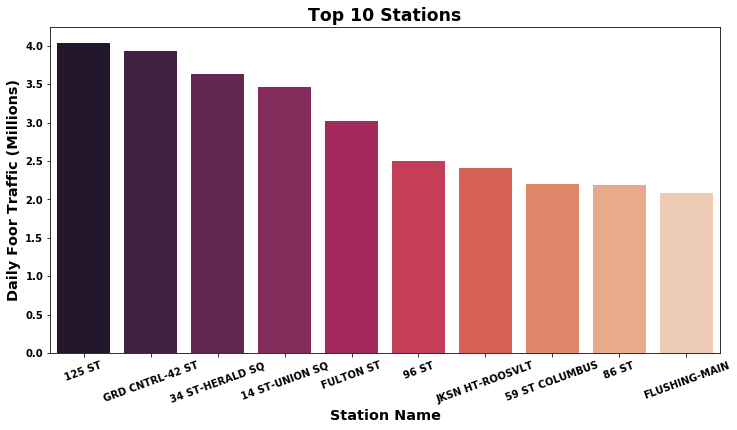

In [9]:
plt.figure(figsize=[12, 6])
font = {'family': 'sans-serif', 'weight': 'bold'}
plt.rc('font', **font)

ax1 = sns.barplot(x = 'STATION', y = total_foottraffic['DAILY_FOOTTRAFFIC_TOTAL']/1e6,
                  data=total_foottraffic,
                  palette="rocket",)
plt.xticks(rotation=20)
ax1.set_xlabel('Station Name', fontdict=font, fontsize='x-large')
ax1.set_ylabel('Daily Foor Traffic (Millions)', fontdict=font, fontsize='x-large')
plt.title('Top 10 Stations', fontdict=font, fontsize='xx-large');

In [10]:
no_good_dec = df_dec19[df_dec19['FOOTTRAFFIC'] < 0]
no_good_dec

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE
5,5,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,23:00:00,REGULAR,7291597,2470898,2019-11-30 23:00:00,-162,1
6,6,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/01/2019,03:00:00,REGULAR,7291644,2470911,2019-12-01 03:00:00,-177,1
7,7,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/01/2019,07:00:00,REGULAR,7291650,2470913,2019-12-01 07:00:00,-52,1
11,11,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/01/2019,23:00:00,REGULAR,7292166,2471137,2019-12-01 23:00:00,-87,1
12,12,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/02/2019,03:00:00,REGULAR,7292191,2471148,2019-12-02 03:00:00,-132,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618624,618624,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,12/20/2019,00:00:00,REGULAR,3111044,394959,2019-12-20 00:00:00,-44,4926
618625,618625,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,12/20/2019,04:00:00,REGULAR,3111044,394959,2019-12-20 04:00:00,-18,4926
618629,618629,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,12/20/2019,20:00:00,REGULAR,3111224,394968,2019-12-20 20:00:00,-7,4926
618635,618635,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,12/14/2019,20:00:00,REGULAR,3033,62,2019-12-14 20:00:00,-1,4927


In [11]:
no_good_june = df_june20[df_june20['FOOTTRAFFIC'] < 0]
no_good_june

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE
1596,1596,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,06/20/2020,00:00:00,REGULAR,885662851,489827979,2020-06-20 00:00:00,-6,39
1597,1597,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,06/20/2020,04:00:00,REGULAR,885662848,489827976,2020-06-20 04:00:00,-6,39
1598,1598,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,06/20/2020,08:00:00,REGULAR,885662841,489827915,2020-06-20 08:00:00,-68,39
1599,1599,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,06/20/2020,12:00:00,REGULAR,885662833,489827850,2020-06-20 12:00:00,-73,39
1600,1600,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,06/20/2020,16:00:00,REGULAR,885662818,489827790,2020-06-20 16:00:00,-75,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619778,619778,TRAM1,R468,00-05-00,RIT-MANHATTAN,R,RIT,06/06/2020,01:00:00,REGULAR,393,0,2020-06-06 01:00:00,-3,4952
619820,619820,TRAM2,R469,00-00-00,RIT-ROOSEVELT,R,RIT,06/06/2020,01:00:00,REGULAR,589325,11771,2020-06-06 01:00:00,-7440,4953
619862,619862,TRAM2,R469,00-00-01,RIT-ROOSEVELT,R,RIT,06/06/2020,01:00:00,REGULAR,3483055,43619,2020-06-06 01:00:00,-7659,4954
619904,619904,TRAM2,R469,00-03-00,RIT-ROOSEVELT,R,RIT,06/06/2020,01:00:00,REGULAR,752705,30598,2020-06-06 01:00:00,-419,4955


In [12]:
no_good_mar = df_mar20[df_mar20['FOOTTRAFFIC'] < 0]
no_good_mar

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE
1638,1638,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,03/21/2020,00:00:00,REGULAR,885669275,489850611,2020-03-21 00:00:00,-17,40
1639,1639,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,03/21/2020,04:00:00,REGULAR,885669265,489850604,2020-03-21 04:00:00,-17,40
1640,1640,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,03/21/2020,08:00:00,REGULAR,885669260,489850562,2020-03-21 08:00:00,-47,40
1641,1641,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,03/21/2020,12:00:00,REGULAR,885669250,489850509,2020-03-21 12:00:00,-63,40
1642,1642,A011,R080,01-03-00,57 ST-7 AV,NQRW,BMT,03/21/2020,16:00:00,REGULAR,885669230,489850443,2020-03-21 16:00:00,-86,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616262,616262,TRAM2,R469,00-00-01,RIT-ROOSEVELT,R,RIT,03/07/2020,00:00:00,REGULAR,3447732,42001,2020-03-07 00:00:00,-15028,4931
616304,616304,TRAM2,R469,00-03-00,RIT-ROOSEVELT,R,RIT,03/07/2020,00:00:00,REGULAR,749060,29502,2020-03-07 00:00:00,-2547,4932
616346,616346,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,03/07/2020,00:00:00,REGULAR,3129643,395952,2020-03-07 00:00:00,-2322,4933
616388,616388,TRAM2,R469,00-05-00,RIT-ROOSEVELT,R,RIT,03/07/2020,00:00:00,REGULAR,3074,62,2020-03-07 00:00:00,-11,4934


In [13]:
df_dec19

,Unnamed: 0,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,TIMESTAMP,FOOTTRAFFIC,TURNSTILE
0,0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,03:00:00,REGULAR,7290785,2470635,2019-11-30 03:00:00,0,1
1,1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,07:00:00,REGULAR,7290795,2470652,2019-11-30 07:00:00,0,1
2,2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,11:00:00,REGULAR,7290860,2470733,2019-11-30 11:00:00,119,1
3,3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,15:00:00,REGULAR,7291051,2470808,2019-11-30 15:00:00,120,1
4,4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,19:00:00,REGULAR,7291396,2470862,2019-11-30 19:00:00,133,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618711,618711,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,04:00:00,REGULAR,5554,420,2019-12-20 04:00:00,0,4928
618712,618712,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,08:00:00,REGULAR,5554,420,2019-12-20 08:00:00,0,4928
618713,618713,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,12:00:00,REGULAR,5554,420,2019-12-20 12:00:00,0,4928
618714,618714,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,12/20/2019,16:00:00,REGULAR,5554,420,2019-12-20 16:00:00,0,4928
